# Introduction
As an investor, you have enough money in hand and plan to invest around Toronto area.
The following analysis will provide some recommendations about what store to be opened and where it should be opened
<br/>
<br/>
The dataset is from wikipedia and I am going to use the foursquare API for explore location venues.
<br/>
<br/>
The method is K-mean cluster and it help us understand the correlation between neighborhood and its surrounding venues

## Part 1 - Preprocessing of data

In [1]:
# BeautifulSoup for scrape web data
from bs4 import BeautifulSoup

# Requests for url
import requests

# pandas for dataframe
import pandas as pd

# folium for map
import folium

# Nominatim for geolocator
from geopy.geocoders import Nominatim

# numpy for nparray
import numpy as np

# matplotlib for diaply K
import matplotlib.pyplot as plt

# cdist for elbow method 
from scipy.spatial.distance import cdist 

# KMeans
from sklearn.cluster import KMeans

# cm for color map
import matplotlib.cm as cm

# colors
import matplotlib.colors as colors

### Scrape and Clean the Wikipedia Data
source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
# Get Url and Create a soup object(HTML) from the source
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

# Search body --> div --> class --> table from soup object(HTML)
table = soup.body.find('div', class_ = 'mw-parser-output').find('table')

# Parse the soup object to string and read it into panda dataframe: [0] for first index of the list
df = pd.read_html(str(table))[0]
df.head(3)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods


In [3]:
# Remove 'Not assigned' from Borough column
df_clean_Borough = df[df.Borough != 'Not assigned']
df_clean_Borough.head(3)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
# Each Borough has many neighbourhoods --> group them together
df_group_neigh = df_clean_Borough.groupby('Postcode', as_index = False).agg({'Borough': 'first', 'Neighbourhood': ', '.join })
df_group_neigh.head(3)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"


In [5]:
# check if there is any missing neighbourhood --> nothing all good
check_df = df_group_neigh.loc[df_group_neigh['Neighbourhood'] == 'Not assigned']
check_df

,Postcode,Borough,Neighbourhood


In [6]:
# check size
df_group_neigh.shape

(103, 3)

### Merge Second Dataset with Latitude and Longitude to the Wikipedia Data

In [7]:
# Second Dataset
LL = pd.read_csv('Geospatial_Coordinates.csv')
LL.head(3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


In [8]:
# Rename 'Postal Code' to 'Postcode'
LL = LL.rename(columns={"Postal Code": "Postcode"})
LL.head(3)

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


In [9]:
merge_df = pd.merge(df_group_neigh, LL, on = "Postcode")
merge_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 2 - Data Explore: Clustering and Visualization

### Explore the Borough 

In [10]:
df = merge_df.groupby('Borough').nunique().sort_values(by=['Neighbourhood'], ascending = False)
df

,Postcode,Borough,Neighbourhood,Latitude,Longitude
Borough,,,,,
North York,24,1,24,24,21
Downtown Toronto,19,1,19,19,18
Scarborough,17,1,17,17,13
Etobicoke,12,1,12,12,10
Central Toronto,9,1,9,9,7
West Toronto,6,1,6,6,6
East Toronto,5,1,5,5,5
East York,5,1,5,5,5
York,5,1,5,5,5


#### As we can see that the top 3 Neighbourhood in Toronto are: 
##### 1. North York
##### 2. Downtown Toronto 
##### 3. Scarborough
####  Since we are interested in open a store, we might want to invest in those Boroughs with higher neighbourhoods

### Neighbourhoods in North York

In [11]:
# Select North York from dataset
north_york_data = merge_df[merge_df['Borough'] == 'North York'].reset_index(drop=True)
north_york_data.head(3)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M2H,North York,Hillcrest Village,43.803762,-79.363452
1,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
2,M2K,North York,Bayview Village,43.786947,-79.385975


In [12]:
address = 'North York, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Scarborough is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough is 43.7543263, -79.44911696639593.


In [13]:
# Set North York coordinate as center and use merge_df dataset for creating circle around it
map_north_york = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(north_york_data['Latitude'], north_york_data['Longitude'], north_york_data['Borough'], north_york_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_north_york)  

# Add title
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Neighbourhoods in North York</b></h3>
             '''
map_north_york.get_root().html.add_child(folium.Element(title_html))

# Display
map_north_york

### Neighbourhoods in Downtown Toronto

In [14]:
# Select Downtown Toronto from dataset
downtown_data = merge_df[merge_df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_data.head(3)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160


In [15]:
address = 'Downtown Toronto, CA'

geolocator = Nominatim(user_agent="dt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Scarborough is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough is 43.6563221, -79.3809161.


In [16]:
# Set Downtown Toronto coordinate as center and use merge_df dataset for creating circle around it
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(downtown_data['Latitude'], downtown_data['Longitude'], downtown_data['Borough'], downtown_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  

# Add title
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Downtown Toronto</b></h3>
             '''
map_downtown.get_root().html.add_child(folium.Element(title_html))
    
#Display
map_downtown

### Neighbourhoods in Scarborough

In [17]:
# Select Scarborough from dataset
scarborough_data = merge_df[merge_df['Borough'] == 'Scarborough'].reset_index(drop=True)
scarborough_data.head(3)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711


In [18]:
address = 'Scarborough, CA'

geolocator = Nominatim(user_agent="sc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Scarborough is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough is 43.773077, -79.257774.


In [19]:
# Set Scarborough coordinate as center and use merge_df dataset for creating circle around it
map_scarborough = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(scarborough_data['Latitude'], scarborough_data['Longitude'], scarborough_data['Borough'], scarborough_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scarborough)  

# Add title
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Neighbourhoods in Scarborough</b></h3>
             '''
map_scarborough.get_root().html.add_child(folium.Element(title_html))

# Display
map_scarborough

## Part 3 - Data Description

From those three folium maps, we notice that the neighbourhoods are much spread out in <b>North York</b> and <b>Scarborough</b> compared with <b>Downtown Toronto</b>. If we want to open a new store, we might as well open a store with more concentrated neighbourhood to increase our visibility to the market. Hence, going forward, we are interesting in explore more about the <b>Downtown Toronto</b> neighbourhood

## Part 4 - Apply Foursquare API

In [20]:
# Foursquare credentials
CLIENT_ID = 'LO0LHYN0LVIRFQR1OR03TIT1U1UVX13QUGH2IVJII50BYIIZ' # your Foursquare ID
CLIENT_SECRET = 'K5F3FI41WQIHBNEM2RC1MVWMY4LEW0NA3BM5ZZ0VXKK1RUS4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LO0LHYN0LVIRFQR1OR03TIT1U1UVX13QUGH2IVJII50BYIIZ
CLIENT_SECRET:K5F3FI41WQIHBNEM2RC1MVWMY4LEW0NA3BM5ZZ0VXKK1RUS4


### Function gets all the neighbourhoods 
The function shows top 100 venues within a radius of 500

In [21]:
# Get upper bound 100
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### All Downtown Toronto Venues from Foursquare API
From the foursquare API we got <b>1318 venues</b> , <b>206 categories</b> in those venues and <b>19 unique neighbourhood</b> in Downtown Toronto 

In [22]:
downtown_venues = getNearbyVenues(names=downtown_data['Neighbourhood'],
                                   latitudes=downtown_data['Latitude'],
                                   longitudes=downtown_data['Longitude']
                                  )

Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park


In [24]:
# check the result size
print(downtown_venues.shape)
downtown_venues.head(3)

(1318, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park


In [25]:
x = downtown_venues['Venue'].count()
print('There are {} venues in Downtown Toronto'.format(x))

y = len(downtown_venues['Venue Category'].unique())
print('There are {} uniques categories.'.format(y))

z = downtown_venues['Neighbourhood'].nunique()
print('There are {} unique heighbourhood in Downtown Toronto'.format(z))

There are 1318 venues in Downtown Toronto
There are 205 uniques categories.
There are 19 unique heighbourhood in Downtown Toronto


### Examinate the Neighbourhood
The chart is listed from high venue neighbourhood to low venue neighbourhood.
<br>We set top 100 venues, and there are <b>7</b> neighbourhood reach that limit

In [26]:
downtown_venues.groupby('Neighbourhood').count().sort_values(by=['Venue'], ascending = False)

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
St. James Town,100,100,100,100,100,100
"Ryerson, Garden District",100,100,100,100,100,100
"Harbourfront East, Toronto Islands, Union Station",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Design Exchange, Toronto Dominion Centre",100,100,100,100,100,100
Stn A PO Boxes 25 The Esplanade,95,95,95,95,95,95
"Chinatown, Grange Park, Kensington Market",87,87,87,87,87,87


## Part 4 - Methodology

### We use one-hot encoding to identify each category
Creating a dummy dataframe and spread out the category as each column
<br>Then, assign each venues to its correponding column (category)

In [27]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
downtown_onehot['Neighbourhood'] = downtown_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_onehot.head(3)

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# check for the shape
downtown_onehot.shape

(1318, 206)

### Group neighbourhood and taking mean frequency on each category
Group each neighbourhood and calculate their <b>mean frequency</b> on each category

In [29]:
downtown_grouped = downtown_onehot.groupby('Neighbourhood').mean().reset_index()
downtown_grouped.head(3)

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,...,0.0,0.0,0.0,0.020000,0.0,0.0,0.01,0.0,0.01,0.0
1,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.017544,0.0,0.0,0.00,0.0,0.00,0.0
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.058824,0.058824,0.117647,0.176471,0.117647,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.0


In [30]:
# check size
downtown_grouped.shape

(19, 206)

### Display the top 3 venues in each neighbourhood in print form

In [31]:
# Display in a print form
num_top_venues = 3

for hood in downtown_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
         venue  freq
0  Coffee Shop  0.07
1   Restaurant  0.04
2         Café  0.04


----Berczy Park----
         venue  freq
0  Coffee Shop  0.07
1       Bakery  0.04
2         Café  0.04


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.08
1  Pizza Place  0.06
2       Bakery  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.16
1  Italian Restaurant  0.05
2      Sandwich Place  0.05


----Chinatown, Grange Park, Kensington Market----
                   venue  freq
0                    Bar  0.07
1                   Café  0.06
2  Vietnamese Restaurant  0.06


----Christie----
           venue  freq
0  Grocery Store  0.22
1           Café  0.17
2           Park  0.11


----

### Transform the print form to dataframe

In [32]:
# function for most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = downtown_grouped['Neighbourhood']

for ind in np.arange(downtown_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar
1,Berczy Park,Coffee Shop,Cocktail Bar,Café
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal
3,"Cabbagetown, St. James Town",Coffee Shop,Bakery,Pizza Place
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place
5,"Chinatown, Grange Park, Kensington Market",Bar,Vietnamese Restaurant,Café
6,Christie,Grocery Store,Café,Park
7,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar
8,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Restaurant
9,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Café,Hotel


### Result
As we go through each 19 Neighbourhood, we find some interesting facts.
<br/>
<br><b>First</b>, most common venues are coffee shops which are occupied 16 out of 19 neighbourhood, cafe will be the second popular ones.
<br/>
<br><b>Second</b>, in those 16 neighbourhoods of common venue of coffee shop, the top 3 are
    <br>1. Queen's Park --------> 0.24
    <br>2. Central Bay Street --> 0.16
    <br>3. Harbourfront ----------> 0.16
<br/>
<br><b>Third</b>, Rosedale most occupied by park, playground and trail. No stores in its top 3 common venue 


### Apply K - Mean Method
First we have to determine what is the optimal K for our clustering and we test K for 1 to 9.
<br/>
<br>I use <b>distortion in Elbow method</b> for K-mean to find optimal K

In [34]:
# Drop 'neighbourhood' column 
X = downtown_grouped.drop('Neighbourhood', 1)

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [35]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.16891892996064187
2 : 0.13374745496185836
3 : 0.1167692563364679
4 : 0.09990698811280713
5 : 0.09127361678920522
6 : 0.08155045490770474
7 : 0.07660646752880056
8 : 0.06471929909379241
9 : 0.05722158851790224


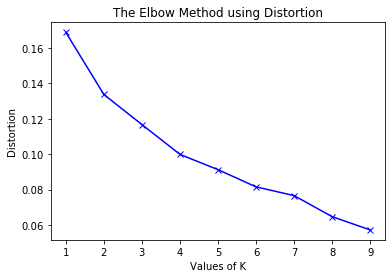

In [36]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

### Result
As you can see the slight sharp turing elbow point is around K=4, so we choose K = 4 

In [37]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1])

In [38]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_merged = downtown_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
downtown_merged = downtown_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

downtown_merged.head() 

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,3,Park,Playground,Trail
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,1,Coffee Shop,Bakery,Pizza Place
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Coffee Shop,Japanese Restaurant,Gay Bar
3,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Park,Pub
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Café


In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], downtown_merged['Neighbourhood'], downtown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Result
As we can the purple circle group is concentrated around the center of downtown Toronto. The red, yellow, and green circle group are far away from the center. Although, all the groups are belong to downtown Toronto 

### Cluster 1

In [40]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 0, downtown_merged.columns[[1] + list(range(4, downtown_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
14,Downtown Toronto,-79.39442,0,Airport Service,Airport Lounge,Airport Terminal


#### Description
The group 1 seems belong to the red group which is south from the downtown. The top 3 common venues are all related to Airport service. If you want to start a bussiness close to this cluster. I suggest to invest in airport services.

### Cluster 2

In [41]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 1, downtown_merged.columns[[1] + list(range(4, downtown_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Downtown Toronto,-79.367675,1,Coffee Shop,Bakery,Pizza Place
2,Downtown Toronto,-79.383160,1,Coffee Shop,Japanese Restaurant,Gay Bar
3,Downtown Toronto,-79.360636,1,Coffee Shop,Park,Pub
4,Downtown Toronto,-79.378937,1,Coffee Shop,Clothing Store,Café
5,Downtown Toronto,-79.375418,1,Coffee Shop,Café,Restaurant
6,Downtown Toronto,-79.373306,1,Coffee Shop,Cocktail Bar,Café
7,Downtown Toronto,-79.387383,1,Coffee Shop,Italian Restaurant,Sandwich Place
8,Downtown Toronto,-79.384568,1,Coffee Shop,Café,Bar
9,Downtown Toronto,-79.381752,1,Coffee Shop,Aquarium,Café
10,Downtown Toronto,-79.381576,1,Coffee Shop,Café,Hotel


#### Description
The group 2 seems belong to the purple group around downtown. The top 3 common venues are related to dining. Coffee shop is the most popular one, followed by cafe and restaurnt. In order to increase visibility of your store, I suggest to invest in food services.

### Cluster 3

In [42]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 2, downtown_merged.columns[[1] + list(range(4, downtown_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
17,Downtown Toronto,-79.422564,2,Grocery Store,Café,Park


#### Description
The group 3 seems belong to the red group west downtown. The top 3 common venues are more diversified. Grocery store is the number. This cluster looks like a residential area. Might suitable for real estate services.  

### Cluster 4

In [43]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 3, downtown_merged.columns[[1] + list(range(4, downtown_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Downtown Toronto,-79.377529,3,Park,Playground,Trail


#### Description
The group 4 seems belong to the yellow group east downtown. The top 3 common venues are related to outdoor activity. This cluster looks like a suburbs. Might not suitable for open any store.

## Part 5 - Recap Result and Discussion
### Mean Frequency Test in category
Most common venues are coffee shops which are occupied 16 out of 19 neighbourhood and cafe is the second and followed by restaurant
<br/>
<br>
In those 16 neighbourhoods of common venue of coffee shop, the top 3 are
    <br>1. Queen's Park --------> 0.24
    <br>2. Central Bay Street --> 0.16
    <br>3. Harbourfront ----------> 0.16
<br/>
<br>CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara. Those places provides mostly airplor services.
<br/>
<br>Rosedale is a suburbs area. It is not ideal for open any store.
<br/>
<br>Christie is a residential area. It has highest frequency of grocery stores.

### Elbow method in K - mean and Clustering
Using elbow method, the optimal K is 4. 
Four cluster groups: purple, red, yellow, and green.
<br/>
<br>Purple --> Center of Downtown Toronto. (high coffe shop/cafe/restaurant)
<br/>
<br>Red --> South of Downtown Toronto (airport)
<br/>
<br>Yellow --> East of Downtown Toronto (suburbs area)
<br/>
<br>Green --> West of Downtown Toronto (high grocery stores)

## Part 6 - Conclusion
Although the analysis is general, it provides some inside of downtown Toronto area for the outsider who wants to invest here. It seems the government has good civil planning for the area. From the k-mean clustering method, I can see clearly that the area is divided by its own functionality. It turns out that all the commerce activity is concentrated in the center of Toronto. On west part, there are residential area. On east part, there are suburbs area for outdoor activity. Finally, the south part is the traveling area. If you want to open a store, certainly, you want to head to downtown to do so for maximizing your store visibility. If you want to invest for airport services, the south is probably your best bet. If you want to buy or do real estate, you might want to head west. Finally, if you want to invest in extreme outdoor activity, you might want to do it in east.  